In [1]:
import pathlib
import tarfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyproj
import xrft
import verde as vd
import harmonica as hm

In [2]:
data_dir = pathlib.Path("..") / "data"
data_path = data_dir / "1038_XYZ.tar.xz"
with tarfile.open(data_path) as archive:
    with archive.extractfile("1038_XYZ/1038/spaulo_rjaneiro_rj.xyz") as data_file:
        raw_data = []
        usecols = [2, 3, 4, 18]        
        read_data = False
        for i, line in enumerate(data_file):
            line = line.decode("latin1")
            if i < 5:
                continue
            if line.strip().startswith("LINE"):
                line_no = int(line.strip().split()[-1][:-1])
                read_data = True
                continue
            # Skip the tie lines because some of them are bad
            if line.strip().startswith("TIE"):
                read_data = False
                continue
            if read_data:
                columns = [float(c.strip()) for c in line.strip().split()]
                raw_data.append([columns[c] for c in usecols] + [line_no])
    full_data = pd.DataFrame(
        raw_data,
        columns=[
            "longitude", 
            "latitude", 
            "total_field_anomaly_nT", 
            "altitude_m",
            "line_number",
        ],
    )
full_data

,longitude,latitude,total_field_anomaly_nT,altitude_m,line_number
0,-43.995285,-23.100388,444.36,300.00,20
1,-43.995255,-23.099503,434.32,300.00,20
2,-43.995224,-23.098618,426.28,300.00,20
3,-43.995193,-23.097733,418.24,300.00,20
4,-43.995178,-23.096832,410.20,300.00,20
...,...,...,...,...,...
393290,-40.966003,-21.270996,11.26,143.87,6500
393291,-40.965988,-21.270111,13.17,143.87,6500
393292,-40.965988,-21.269211,11.08,143.87,6500
393293,-40.965973,-21.268311,11.00,143.87,6500


In [3]:
projection = pyproj.Proj(proj="merc", lat_ts=full_data.latitude.mean())
full_data = full_data.assign(**{
    name: coord 
    for name, coord in zip(
        ["easting_m", "northing_m"], projection(full_data.longitude, full_data.latitude)
    )
})

In [4]:
region = [-42.64, -41.9, -22.6, -22]
data = full_data[vd.inside((full_data.longitude, full_data.latitude), region)]
data

,longitude,latitude,total_field_anomaly_nT,altitude_m,line_number,easting_m,northing_m
148798,-42.639984,-22.290527,-16.56,151.49,2800,-4.399187e+06,-2.345018e+06
148799,-42.639969,-22.291397,-43.47,162.46,2800,-4.399186e+06,-2.345115e+06
148800,-42.639954,-22.292267,-65.38,170.69,2800,-4.399184e+06,-2.345211e+06
148801,-42.639938,-22.293152,-74.29,173.43,2800,-4.399183e+06,-2.345309e+06
148802,-42.639923,-22.294022,-67.20,170.08,2800,-4.399181e+06,-2.345406e+06
...,...,...,...,...,...,...,...
282753,-41.905685,-22.497009,163.33,143.87,4600,-4.323430e+06,-2.367927e+06
282754,-41.905685,-22.497879,175.29,142.34,4600,-4.323430e+06,-2.368023e+06
282755,-41.905701,-22.498734,180.25,140.51,4600,-4.323431e+06,-2.368118e+06
282756,-41.905701,-22.499588,175.21,138.68,4600,-4.323431e+06,-2.368213e+06


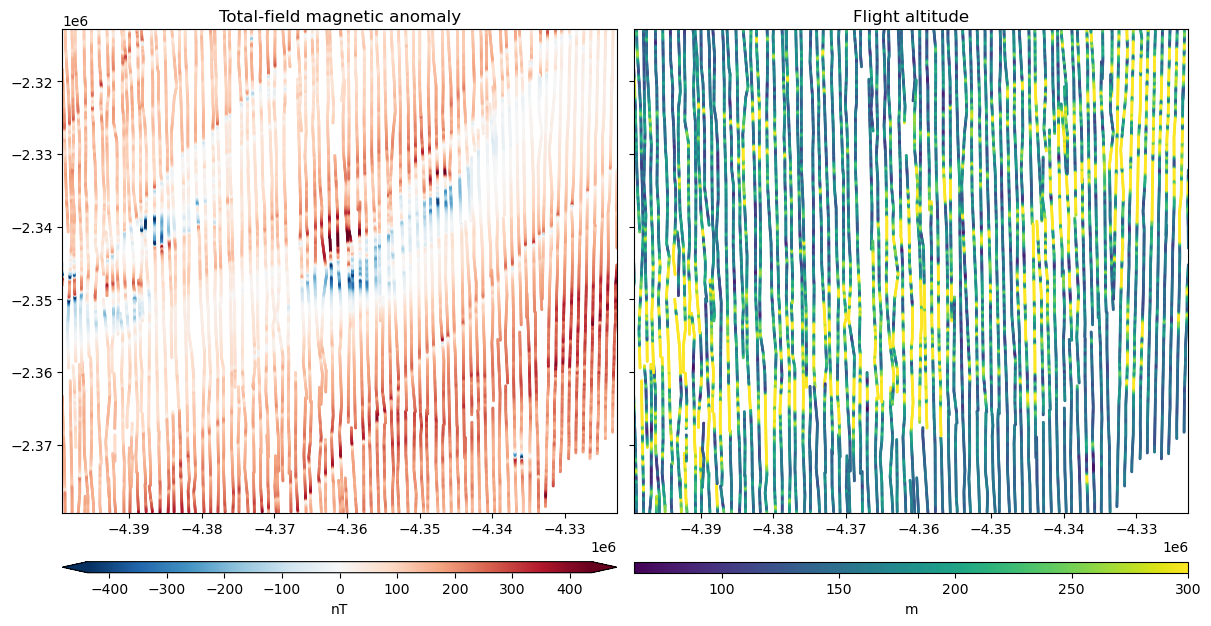

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 7), sharey=True, layout="constrained")
for ax in axes:
    ax.set_aspect("equal")
    ax.set_xlim(data.easting_m.min(), data.easting_m.max())
    ax.set_ylim(data.northing_m.min(), data.northing_m.max())
ax = axes[0]
ax.set_title("Total-field magnetic anomaly")
scale = 0.5 * vd.maxabs(data.total_field_anomaly_nT)
tmp = ax.scatter(
    data.easting_m, 
    data.northing_m, 
    s=1, 
    c=data.total_field_anomaly_nT, 
    cmap="RdBu_r",
    vmin=-scale,
    vmax=scale,
)
cb_kwargs = dict(aspect=50, pad=0.01, orientation="horizontal")
fig.colorbar(tmp, ax=ax, label="nT", extend="both", **cb_kwargs)
ax = axes[1]
ax.set_title("Flight altitude")
tmp = ax.scatter(
    data.easting_m, 
    data.northing_m, 
    s=1, 
    c=data.altitude_m, 
    cmap="viridis",
)
fig.colorbar(tmp, ax=ax, label="m", **cb_kwargs)
plt.show()

In [6]:
%%time
spacing = 250
region_proj = vd.get_region((data.easting_m, data.northing_m))
eqs = hm.EquivalentSourcesGB(damping=1e1, depth=2250, block_size=spacing, random_state=42)
coordinates = (data.easting_m, data.northing_m, data.altitude_m)
eqs.fit(coordinates, data.total_field_anomaly_nT)

/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/harmonica/_equivalent_sources/gradient_boosted.py:224: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  data = data.ravel()
/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/verde/blockreduce.py:179: FutureWarning: The provided callable <function median at 0x71cb8013d580> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  blocked = pd.DataFrame(columns).groupby("block").aggregate(reduction)
/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/verde/blockreduce.py:236: FutureWarning: The provided callable <function median at 0x71cb8013d580> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable

CPU times: user 2min 2s, sys: 3.41 s, total: 2min 5s
Wall time: 20.4 s


EquivalentSourcesGB(block_size=250, damping=10.0, depth=2250, random_state=42)

In [7]:
grid_coords = vd.grid_coordinates(region_proj, spacing=spacing, extra_coords=data.altitude_m.max())
grid = eqs.grid(
    grid_coords,
    data_names="total_field_anomaly",
)
grid

<xarray.Dataset> Size: 1MB
Dimensions:              (northing: 267, easting: 306)
Coordinates:
  * easting              (easting) float64 2kB -4.399e+06 ... -4.323e+06
  * northing             (northing) float64 2kB -2.379e+06 ... -2.313e+06
    upward               (northing, easting) float64 654kB 300.0 300.0 ... 300.0
Data variables:
    total_field_anomaly  (northing, easting) float64 654kB 175.4 176.2 ... 65.81
Attributes:
    metadata:  Generated by EquivalentSourcesGB(block_size=250, damping=10.0,...

In [8]:
residuals = data.total_field_anomaly_nT - eqs.predict(coordinates)

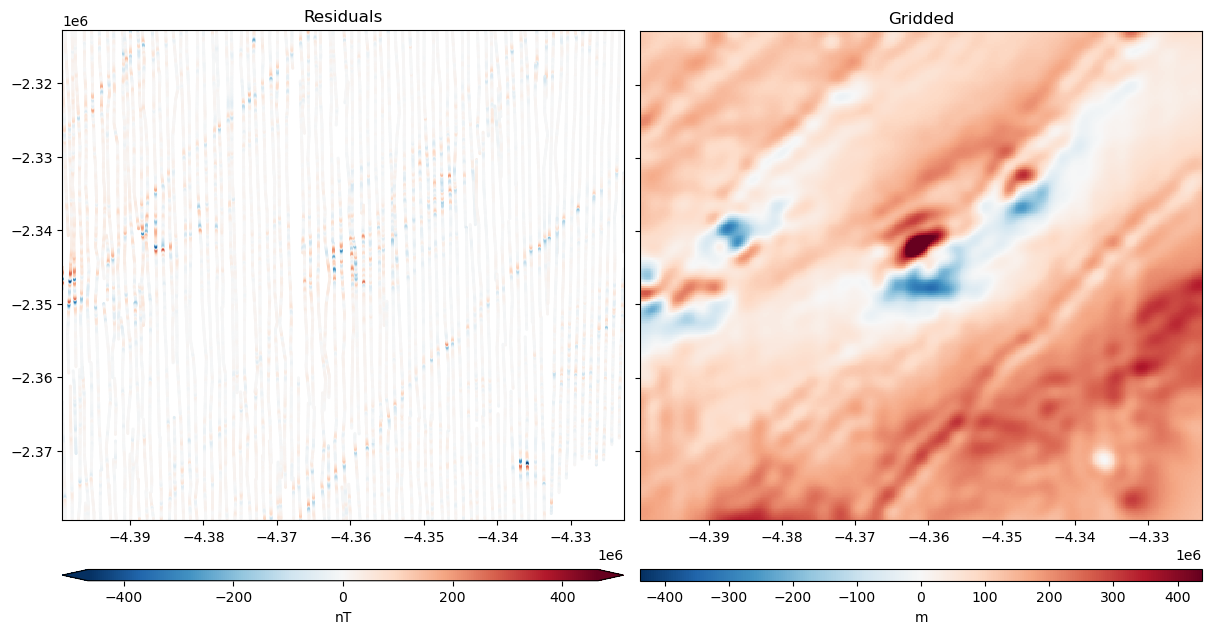

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 7), sharey=True, layout="constrained")
for ax in axes:
    ax.set_aspect("equal")
    ax.set_xlim(data.easting_m.min(), data.easting_m.max())
    ax.set_ylim(data.northing_m.min(), data.northing_m.max())
scale = vd.maxabs(residuals)
ax = axes[0]
ax.set_title("Residuals")
tmp = ax.scatter(
    data.easting_m, 
    data.northing_m, 
    s=1, 
    c=residuals, 
    cmap="RdBu_r",
    vmin=-scale,
    vmax=scale,
)
cb_kwargs = dict(aspect=50, pad=0.01, orientation="horizontal")
fig.colorbar(tmp, ax=ax, label="nT", extend="both", **cb_kwargs)
ax = axes[1]
scale = 0.5 * vd.maxabs(data.total_field_anomaly_nT)
ax.set_title("Gridded")
tmp = grid.total_field_anomaly.plot(ax=ax, add_colorbar=False, add_labels=False, vmin=-scale, vmax=scale, cmap="RdBu_r")
fig.colorbar(tmp, ax=ax, label="m", **cb_kwargs)
plt.show()

In [10]:
# Place the height as a variable instead of non-dimensional coordinates
# because xrft.pad can't handle non-dimensional coordinates
if "upward" in grid:
    grid = grid.assign(height=grid.upward).drop_vars("upward")
grid["deriv_east"] = hm.derivative_easting(grid.total_field_anomaly)
grid["deriv_north"] = hm.derivative_northing(grid.total_field_anomaly)
pad_width = {
    "easting": grid.easting.size // 3,
    "northing": grid.northing.size // 3,
}
padded = xrft.pad(grid.total_field_anomaly, pad_width, mode="linear_ramp", constant_values=None)
grid["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)
grid

/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 3MB
Dimensions:              (northing: 267, easting: 306)
Coordinates:
  * easting              (easting) float64 2kB -4.399e+06 ... -4.323e+06
  * northing             (northing) float64 2kB -2.379e+06 ... -2.313e+06
Data variables:
    total_field_anomaly  (northing, easting) float64 654kB 175.4 176.2 ... 65.81
    height               (northing, easting) float64 654kB 300.0 300.0 ... 300.0
    deriv_east           (northing, easting) float64 654kB 0.003149 ... -0.00...
    deriv_north          (northing, easting) float64 654kB 0.01141 ... 0.005858
    deriv_up             (northing, easting) float64 654kB -0.02159 ... -0.0138
Attributes:
    metadata:  Generated by EquivalentSourcesGB(block_size=250, damping=10.0,...

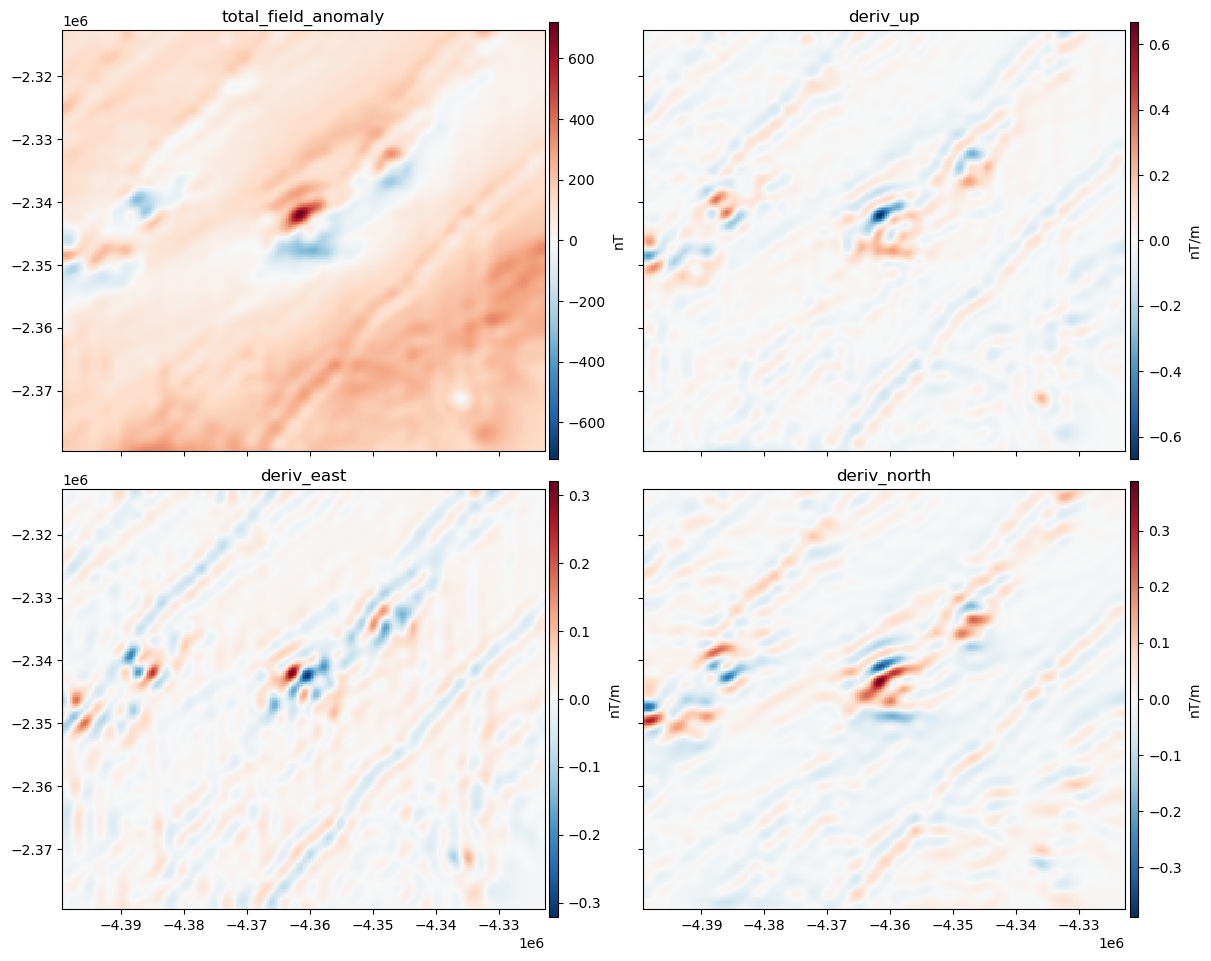

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12, 9.5), sharex=True, sharey=True, layout="constrained")
for ax in axes.ravel():
    ax.set_aspect("equal")
    ax.set_xlim(data.easting_m.min(), data.easting_m.max())
    ax.set_ylim(data.northing_m.min(), data.northing_m.max())

variables = [
    "total_field_anomaly",
    "deriv_up",
    "deriv_east",
    "deriv_north",
]
units = ["nT", "nT/m", "nT/m", "nT/m"]
for ax, var, unit in zip(axes.ravel(), variables, units):
    scale = vd.maxabs(grid[var])
    ax.set_title(var)
    tmp = grid[var].plot(ax=ax, add_colorbar=False, add_labels=False, vmin=-scale, vmax=scale, cmap="RdBu_r")
    fig.colorbar(tmp, ax=ax, label=unit, aspect=50, pad=0.01, orientation="vertical")
plt.show()

In [12]:
grid.to_netcdf(data_dir / "rio-de-janeiro-magnetic.nc")